# Predicting Tommorrow's Closing Price using Linear Regression

## **Objective**
The goal of this prjoect is to use machine learning to create a linear regression model that predicts tomorrow's closing price of the S&P500 index. As of the projects creation that date would be 9/2/2025.

In [20]:
#Downloads
!pip install yfinance
#Import packages and yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

#Get last 11 years of SP500 data from yahoo finance
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="11y").drop("Dividends", axis=1).drop("Stock Splits", axis=1) #Drops non-relevant columns
sp500 = sp500.reset_index()
sp500['Date'] = sp500['Date'].dt.date

#Exploratory Data Analysis
sp500.isna().sum() #Checks for missing values
sp500.describe()   #Generates summary statistics of data
sp500.info()       #Describes data types of columns
sp500.head()       #Shows preview of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2766 entries, 0 to 2765
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2766 non-null   object 
 1   Open    2766 non-null   float64
 2   High    2766 non-null   float64
 3   Low     2766 non-null   float64
 4   Close   2766 non-null   float64
 5   Volume  2766 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 129.8+ KB


,Date,Open,High,Low,Close,Volume
0,2014-09-02,2004.069946,2006.119995,1994.849976,2002.280029,2819980000
1,2014-09-03,2003.569946,2009.280029,1998.140015,2000.719971,2809980000
2,2014-09-04,2001.670044,2011.170044,1992.540039,1997.650024,3072410000
3,2014-09-05,1998.000000,2007.709961,1990.099976,2007.709961,2818300000
4,2014-09-08,2007.170044,2007.170044,1995.599976,2001.540039,2789090000


## **Feature Engineering**
To improve the predictive power of the model feature were engineered. These features are lagged closes for yesterday and 5 days ago, the 5, 50, 100 moving averages, daily return %, and volatility.

In [21]:
#Engineer features for model:
#1. Lagged closes
sp500["1_day_lag"] = sp500["Close"].shift(1) #Yesterday's close
sp500["5_day_lag"] = sp500["Close"].shift(5) #Close from 5 trading days ago
#2. Moving Averages
sp500["ma_5"] = sp500["Close"].rolling(5).mean() #5 day moving average
sp500["ma_50"] = sp500["Close"].rolling(50).mean() #50 day moving average
sp500["ma_100"] = sp500["Close"].rolling(100).mean() #100 day moving average
#3. Daily Returns
sp500["daily_return"] = sp500["Close"].pct_change()
#4. Volatility
sp500["volatility"] = sp500["daily_return"].rolling(5).std()
#Drop NA values
sp500.dropna(inplace=True)

# **Model Training**
Using machine learning, a linear regression model is trained on the data using the engineered features. This results in predicted closing prices for the last 2.2 years (test size is 20% of Data set).

In [22]:
#Generate Model
#Define X and y
X = sp500[["1_day_lag", "5_day_lag", "ma_5", "ma_50", "ma_100", "daily_return", "volatility"]] #Engineered features
y = sp500["Close"].shift(-1) #Target is next day closing price
X, y = X.iloc[:-1], y.iloc[:-1] #Drop NA value generated by shift
#Split X and y into train and test variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=False)
#Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Fit model (Linear Regression)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
#Predict target
y_pred_lr = lr.predict(X_test_scaled)

## **Model Performance**
Using mean squared error (MSE), root mean squared error (RMSE), and the coefficient of determination (R^2), the performance of the model can be measured. From the results attained, the model, on average, predicts a closing price that is $58.66 away from the actual price. It can also be determined that the model explains 99% of the variation in the closing price. This is suspicious and will be discussed further in the "Model Limitations" section.

In [23]:
#Evalutate model perfromance
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred_lr)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {R2}")

Mean Squared Error: 3441.4354260313276
Root Mean Squared Error: 58.663748823539464
R2 Score: 0.9911611997835663


## **Visualization**
The chart belows shows the predicted prices and the actual prices of the S&P500 index since July of 2023. The regression line follows the actual closing prices failry well.

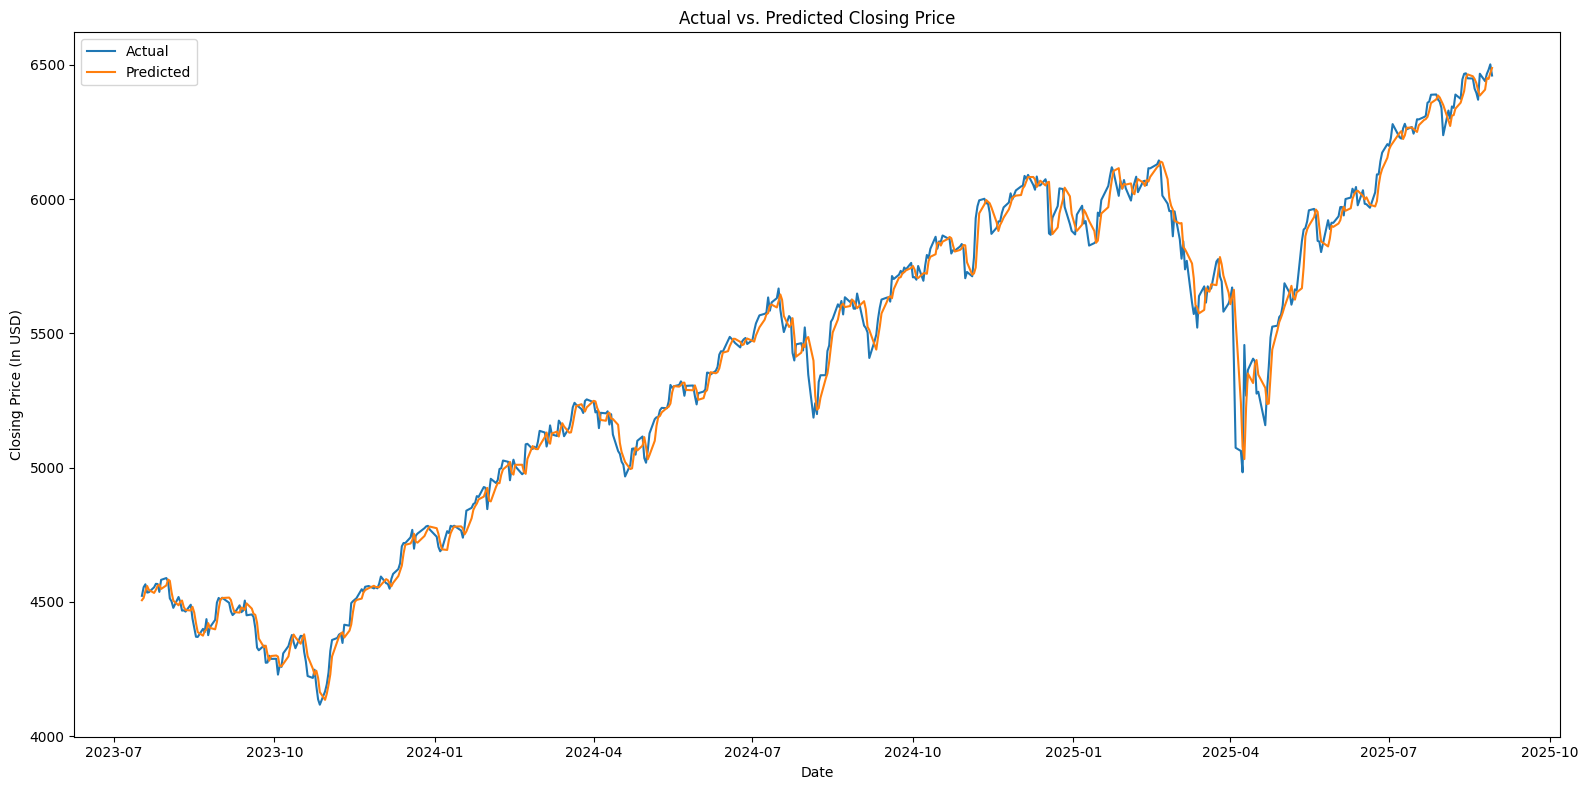

In [42]:
#Plot Actual vs. Predicted
plt.figure(figsize=(16,8))
plt.plot(sp500['Date'].iloc[-len(y_test):],y_test.values,label='Actual')
plt.plot(sp500['Date'].iloc[-len(y_test):],y_pred_lr,label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price (In USD)')
plt.title('Actual vs. Predicted Closing Price')
plt.tight_layout()
plt.show()

## Predicting Tomorrow's Closing Price
The model predicts a closing price of ≈$6488.27 for the trading day 9/2/2025.

In [25]:
#Predicting next trading day closing price (9/2/2025)
# Select the last row of the engineered features DataFrame
last_data_point = X.iloc[-1]

# Convert the last data point to a DataFrame with the same column names as the training data
last_data_point_df = pd.DataFrame(last_data_point).transpose()

# Scale the last data point using the fitted scaler
last_data_point_scaled = scaler.transform(last_data_point_df)

# Predict the next day's closing price
predicted_price = lr.predict(last_data_point_scaled)

print(f"Predicted next day closing price: {predicted_price[0]}")

Predicted next day closing price: 6488.266177787325


## **Model Limitations**
As previously mentioned, the model achieved a suspiciously high R^2 score. There are some important things that must be considered about this model.
1. **Autocorrelation**
   * Stock prices are highly autocorrelated, meaning today’s closing price is usually similar to tomorrow’s. This can make the model appear accurate without capturing new information.
2. **Past results ≠ Future results**
   * The model captures historical trends of the S&P 500, but past performance does not guarantee future outcomes. Unexpected market shifts may cause the model to fail in predicting future prices.
3. **Risk of overfitting**
   * By relying on historical trends and short-term fluctuations, the model can capture random noise rather than meaningful patterns. Overfitting occurs when the model memorizes past data, which reduces its ability to generalize to unseen market conditions.
4. **Limited feature set**
   * The model was trained using only a small number of features, whereas real-life prices are influenced by a myriad of external factors such as macroeconomics, geopolitics, corporate earnings, investor sentiments, etc. Excluding these features limits the model’s predictive capability.
5. **Testing and Validation Limitations**
   * The model was tested on only one block of recent data. Stock prices are sequential, so this does not fully show how it would perform in varying market conditions. More realistic methods, like rolling-window or walk-forward testing, would provide a better estimate of how well the model works on truly unseen data.

## **Summary**
Overall, while the model may show strong performance indicators, its high R² and low error values can be misleading. Many of the limitations discussed above could be addressed with additional features or more robust validation methods. However, predicting stock prices is inherently challenging due to the complex nature of financial markets. Prices are influenced by countless factors, and no single model can perfectly forecast future movements. Attempting to create such a model is, in essence, a core aspect of finance — trying to anticipate the unpredictable behavior of markets.


